# Personalizing Sustainable Agriculture with Causal Machine Learning

### *Tackling Climate Change with Machine Learning Workshop @ NeurIPS'22* | **Best Proposal Paper**

#### Authors: Georgios Giannarakis, Vasileios Sitokonstantinou, Roxanne Suzette Lorilla, Charalampos Kontoes | National Observatory of Athens, Greece

This jupyter notebook contains the code required to implement and reproduce the "Personalizing Sustainable Agriculture with Causal Machine Learning" paper.

**NB**: Due to privacy reasons, some data cannot be open-sourced. This includes crop declaration data (found in ```IACS``` dataframes in the script) and soil organic carbon content values (found in the ```SOC``` dataframe). For retrieving crop declaration data via an Earth Observation (EO) based service such as [EuroCrops](https://www.eurocrops.tum.de/). To derive parcel-level SOC content values, we again refer the interested reader to the EO literature (https://doi.org/10.1016/j.rse.2020.111793), which is what was also used in the paper.

### Abbreviations

- SOC = Soil Organic Carbon
- IACS = Integrated Administration and Control System
- LPIS = Land Parcel Identification System
- ECO = LPIS with an indicator for fields practicing eco-friendly practices that year
- ERA5 = The fifth generation ECMWF reanalysis for the global climate and weather

Note that IACS and LPIS are used interchangeably. They simply refer to the crop declarations (aka crop type map) of a single year. These are not inferred via remote sensing: it is simply what the farmer declared (the ground truth).

### High-level flow:

1. Create dataframe for 2021 with SOC, IACS, ECO info
2. Create dataframe for 2020 with IACS, ECO info
3. Match geometries and filter for parcels whose geometry remained constant
4. Extend matched dataframe with ERA5 info
5. Causal analysis with EconML
6. Visualizing the results

# Imports

Refer to ```requirements.txt``` file.

In [1]:
import pandas as pd
from pandas import read_excel
import numpy as np
import os
import geopandas as gpd
import shapely
import netCDF4
import xarray as xr 
import rioxarray as rio
import matplotlib
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LogisticRegression, LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from econml.dml import SparseLinearDML, LinearDML, CausalForestDML

### 1. Data from 2021

In [2]:
# Read IACS/SOC 2021
file_dir = '/nfs/data2/EIFFEL/'
soc21 = gpd.read_file(os.path.join(file_dir, 'Lithuania_SOC_parcel/lithuania_soc_fields.shp')).set_crs('EPSG:3346').to_crs('EPSG:3857')

In [3]:
# Read English crop codes
file_dir = '/nfs/data2/EIFFEL/'
my_sheet = 'Sheet1'
file_name = 'paseliu2020_kodai_ENG.xls'
crop_codes = pd.read_excel(os.path.join(file_dir, file_name), sheet_name = my_sheet)

In [4]:
# Augment SOC21 with English info
soc21 = soc21.rename(columns={'PSL_KODAS': 'code'}).merge(crop_codes, on='code', how='left')

In [5]:
# Read ECO 2021
file_dir = '/nfs/data2/EIFFEL/'
eco = gpd.read_file(os.path.join(file_dir, 'eco_shp/eco_21.shp')).set_crs('EPSG:3346').to_crs('EPSG:3857')

In [6]:
# create id and drop duplicates on ECO21 fields to ensure 1-1 outcome when merging on id
eco["id"] = eco["BLK_NR"] + "-" + eco["LAUKO_NR"] + "-" + eco["PSL_KODAS"]
eco["id"] = eco.id.astype(str)
eco = eco.drop_duplicates(subset=['id'])

In [7]:
# create id and drop duplicates on SOC21 to ensure 1-1 outcome when merging on id
soc21["id"] = soc21["BLK_NR"] + "-" + soc21["LAUKO_NR"] + "-" + soc21["code"]
soc21 = soc21.drop_duplicates(subset=['id'])

In [8]:
# left join SOC21 with ECO21 on id and drop irrelevant columns
soc_eco21 = soc21.merge(eco[["Programa", "RGR", "id"]], on='id', how='left')
soc_eco21 = soc_eco21.drop(columns=["BLK_NR", "LAUKO_NR"])

In [9]:
# create dummies for the 8 crop groups found in the dataset
soc_eco21 = pd.get_dummies(soc_eco21, columns=['group'], prefix='', prefix_sep='')

In [10]:
# create is_eco column (binary)
soc_eco21['Programa'] = soc_eco21['Programa'].fillna(0)
soc_eco21['is_eco'] = np.where(soc_eco21.Programa == 0, 0, 1)

### 2. Data from 2020

In [12]:
# Read IACS20 (henceforth SOC20 for symmetry)
os.chdir('/nfs/data2/EIFFEL/IACS/inc_387887_2020')
soc20 = gpd.read_file('inc_387887_2020.shp').set_crs('EPSG:3346').to_crs('EPSG:3857')

In [13]:
# Augment SOC20 with English info
soc20 = soc20.rename(columns={'PSL_KODAS': 'code'}).merge(crop_codes, on='code', how='left')

In [14]:
# Read ECO20
file_dir = '/nfs/data2/EIFFEL/'
eco20 = gpd.read_file(os.path.join(file_dir, 'eco_shp/eco_20.shp')).set_crs('EPSG:3346').to_crs('EPSG:3857')

In [15]:
# create id and drop duplicates on ECO20 fields to ensure 1-1 outcome when merging on id
eco20["id"] = eco20["BLK_NR"] + "-" + eco20["LAUKO_NR"] + "-" + eco20["PSL_KODAS"]
eco20["id"] = eco20.id.astype(str)
eco20 = eco20.drop_duplicates(subset=['id'])

In [16]:
# create id and drop duplicates on SOC20 fields to ensure 1-1 outcome when merging on id
soc20["id"] = soc20["BLK_NR"] + "-" + soc20["LAUKO_NR"] + "-" + soc20["code"]
soc20 = soc20.drop_duplicates(subset=['id'])

In [17]:
# left join SOC20 with ECO20 on id and drop irrelevant columns
soc_eco20 = soc20.merge(eco20[["Programa", "RGR", "id"]], on='id', how='left')
soc_eco20 = soc_eco20.drop(columns=["BLK_NR", "LAUKO_NR"])

In [18]:
# create dummies for the 8 crop groups found in the dataset
soc_eco20 = pd.get_dummies(soc_eco20, columns=['group'], prefix='', prefix_sep='')

In [19]:
# create is_eco column (binary)
soc_eco20['Programa'] = soc_eco20['Programa'].fillna(0)
soc_eco20['is_eco'] = np.where(soc_eco20.Programa == 0, 0, 1)

### 3. Match 2021-2020 geometries to find parcels constant in space and time

Matching is done as follows: First, initialize a spatial index on the relevant geometries. Then, apply the ```geopandas.sindex.SpatialIndex.nearest``` to the index with the second geometry as argument. Finally, calculate the centroid distance between each 2021 parcel and its 2020 matched counterpart, and only keep the parcels whose centroids were "close enough" (based on an arbitrary threshold). These are the "constant" (over the period of reference) parcels.

In [20]:
s21 = soc_eco21.geometry.sindex # initialize spatial index
s20 = soc_eco20.geometry.sindex # initialize spatial index

In [21]:
# see https://geopandas.org/en/stable/docs/reference/api/geopandas.sindex.SpatialIndex.nearest.html
matched = s20.nearest(soc_eco21.geometry, max_distance=0.5, return_all = False) # quite fast

In [22]:
# extract the centroids for second-level distance-based matching
a = soc_eco21.iloc[matched[0]].geometry.centroid
b = soc_eco20.iloc[matched[1]].geometry.centroid

In [23]:
# calculate 1-1 distance between elements of a and b
dis_array = a.distance(b, align=False)

In [24]:
# select matched 2021 rows and augment with distance from their 2020 match to filter later
soc_eco21 = soc_eco21.iloc[matched[0]].copy()
soc_eco21['distance'] = dis_array

In [25]:
# select matched 2020 rows and drop obsolete 2020 geometry
soc_eco20 = soc_eco20.iloc[matched[1]].copy()
soc_eco20 = soc_eco20.drop(columns=['geometry'])

In [26]:
# horizontal concatenation of 2021 and 2020 data
final = pd.concat([soc_eco21.reset_index(drop=True), soc_eco20.reset_index(drop=True)], axis=1)

In [27]:
# only keep 2021 geometries whose distance from their 2020 match is "small"
final = final[final['distance'] < 3]

### 4. Augment data with ERA5 climate indices

ERA5 data are open-source. See ```cds-api-data-retrieval.ipynb``` for the API call used to retrieve them in ```xarray``` format.

In [28]:
os.chdir('/home/noa2/EIFFEL-git/data/raw')
era = xr.open_dataset('era').rio.write_crs("EPSG:4326").rio.reproject("EPSG:3857") # ERA5 uses 4326

In [29]:
# select Jan 2020 - Dec 2021 data, and average over the months to get one value per ERA5 cell
era = era.sel(time=slice('2020-01-01T00:00:00.000000000', '2021-12-01T00:00:00.000000000'))
era = era.mean(dim='time')
era = era.to_dataframe().reset_index()

In [30]:
# create dataframe from centroids of each ERA5 cell (hence point geometries)
era = gpd.GeoDataFrame(era, geometry=gpd.points_from_xy(era.x, era.y)).set_crs("EPSG:3857")

In [31]:
# to create an ERA5 square grid, calculate the distance between two neighboring ERA5 centroids and create a square buffer
a1 = era.geometry[1]
a2 = era.geometry[2]
buf = a1.distance(a2) / 2
era.geometry = era.geometry.buffer(buf, cap_style = 3)

In [32]:
# Left spatial join final with era, matching a final polygon with an ERA5 cell if the former is covered by the latter
# covered by in the following sense: https://shapely.readthedocs.io/en/stable/manual.html
final_era = gpd.sjoin(final, era, how="left", op="covered_by") # quite fast

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.


In [33]:
# the final, matched 2020-21 dataset augmented with ERA5
final_era.columns

Index(['code', 'lithuania_', 'geometry', 'name', 'group_i', 'id', 'Programa',
       'RGR', 'I group', 'II group', 'III group', 'IV group', 'V group',
       'VI group', 'VII group', 'VIII group', 'is_eco', 'distance', 'code',
       'name', 'group_i', 'id', 'Programa', 'RGR', 'I group', 'II group',
       'III group', 'IV group', 'V group', 'VI group', 'VII group',
       'VIII group', 'is_eco', 'index_right', 'x', 'y', 'spatial_ref', 'u10',
       'v10', 'd2m', 't2m', 'evabs', 'evaow', 'evatc', 'evavt', 'fal',
       'lai_hv', 'lai_lv', 'pev', 'ro', 'src', 'skt', 'asn', 'snowc', 'rsn',
       'sde', 'sd', 'es', 'sf', 'smlt', 'stl1', 'stl2', 'stl3', 'stl4', 'ssro',
       'slhf', 'ssr', 'str', 'sp', 'sro', 'sshf', 'ssrd', 'strd', 'tsn', 'e',
       'tp', 'swvl1', 'swvl2', 'swvl3', 'swvl4'],
      dtype='object')

In [34]:
# smart deduplication of column names that would cause downstream problems
final_era.columns = pd.io.parsers.base_parser.ParserBase({'names':final_era.columns, 'usecols':None})._maybe_dedup_names(final_era.columns)

In [35]:
# define double_eco treatment, binary indicator for eco-friendly parcels in both years
final_era['double_eco'] = np.where((final_era['is_eco'] == 1)  & (final_era['is_eco.1'] == 1), 1, 0)

In [36]:
# drop obsolete info and na values
final_era = final_era.drop(columns=['RGR', 'RGR.1']).dropna()

### 5. Causal analysis with EconML

In [37]:
# standard scaler for all ERA5 data
scaler = StandardScaler()
final_era.iloc[:, 36:78] = scaler.fit_transform(final_era.iloc[:, 36:78])

In [38]:
# create "crop sequence" variable, concatenating the 2020 and 2021 crop code for each parcel
final_era['crop_seq'] = final_era['code'] + '-' + final_era['code.1']

In [39]:
# the most prominent crop sequences found in the dataset
final_era.crop_seq.value_counts()[:5]

DGP-DGP    40818
GPŽ-GPŽ    19561
KVŽ-KVŽ    11242
KVŽ-RAŽ     7987
KTŽ-KTŽ     7381
Name: crop_seq, dtype: int64

In [40]:
# the plan is to account for heterogeneity caused by different crops
# create dummies for the most prominent crop sequences only (those seen > 10000 times)
cats = final_era.crop_seq.value_counts()[lambda x: x > 10000].index
temp = pd.get_dummies(pd.Categorical(final_era['crop_seq'], categories=cats))

In [41]:
# horizontal concatenation of the dummies to the final dataset
final_era = pd.concat([final_era, temp], axis=1)

In [42]:
final_era = final_era.dropna()

In [43]:
# in these preliminary results, we restrict the dataset to the three most prominent crop combinations, and learn CATEs for them
final_era_f = final_era.loc[~((final_era['DGP-DGP'] == 0) & (final_era['GPŽ-GPŽ'] == 0) & (final_era['KVŽ-KVŽ'] == 0)), :]

In [44]:
# Y = outcome, T = treatment, W = controls, X = heterogeneity controls
Y = final_era_f.lithuania_
T = final_era_f.double_eco.astype(int) # only 7k double eco
W = final_era_f.iloc[:, 36:78] # ERA5, if need crop groups on W can use e.g. np.r_[3:46, 51:59]
X = final_era_f.iloc[:, -3:] # the type of rotation, with binary variables for the most prominent rotations

In [45]:
# further restrict ERA5 controls to the most significant climate variables
W = final_era_f.loc[:, ['u10', 'v10', 't2m', 'evavt', 'lai_lv', 'ro', 'stl1', 'tp', 'swvl1']]

In [46]:
# train a LinearDML, do not fit cate intercept here for simpler interpretation of point estimates
est0 = LinearDML(model_y=RandomForestRegressor(random_state=42), model_t=RandomForestClassifier(random_state=42), random_state=123, fit_cate_intercept = False)
est0.fit(Y, T, X=X, W=W)

In [47]:
# inference on learned causal parameters
est0.summary()

CATE Intercept Results:  No intercept was fitted!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,0.058,0.141,0.407,0.684,-0.22,0.335
X1,-0.077,0.174,-0.443,0.658,-0.418,0.264
X2,-0.088,0.275,-0.319,0.749,-0.628,0.452


In [48]:
# average CATEs over X to get a simple ATE estimate (inference only over the training set restricted to most prominent crop combination)
est0.effect(X).mean()

### 6. Visualizing the results

In [49]:
# restrict the big dataset to random bbox (includes crop combinations are than the prominent ones)
eco_to_viz0 = final_era.cx[2840415.203:2853466.007, 7252025.724:7261150.492].geometry.reset_index().drop(columns=['index'])

In [50]:
# assign the corresponding estimated CATEs to the new df
eco_to_viz0 = eco_to_viz0.assign(C=est0.effect(final_era.cx[2840415.203:2853466.007, 7252025.724:7261150.492].iloc[:, -3:]))

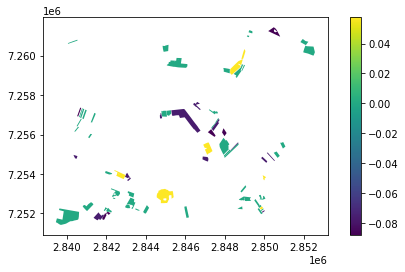

In [51]:
# visualize CATE map with geopandas (all rows)
eco_to_viz0.plot(column='C', legend=True, figsize = (8,4));

In [52]:
# export shape file for QGIS beautification
eco_to_viz0.to_file("results_all.shp")

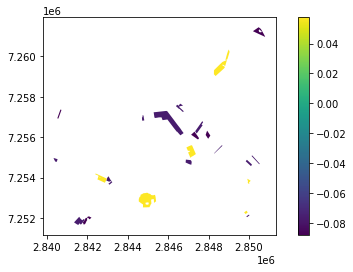

In [53]:
# do the same for the restricted dataset (see parcels it also saw during training)
eco_to_viz1 = final_era_f.cx[2840415.203:2853466.007, 7252025.724:7261150.492].geometry.reset_index().drop(columns=['index'])
eco_to_viz1 = eco_to_viz1.assign(C=est0.effect(final_era_f.cx[2840415.203:2853466.007, 7252025.724:7261150.492].iloc[:, -3:]))
eco_to_viz1.plot(column='C', legend=True, figsize = (8,4));

In [54]:
# export shape file for QGIS beautification
eco_to_viz1.to_file("results_X_only.shp")